# Lecture 5
## Model Selection and Problems in High Dimensions

Run the following cell with `Shift + Enter` to watch the video.

In [ ]:
IRdisplay::display_html('<iframe width="640" height="360" src="https://tube.switch.ch/embed/19aa3363" frameborder="0" allow="fullscreen" allowfullscreen></iframe>')

Let us generate the data set with 1000 normally distributed predictors and a
response that is independent of the predictors.

In [ ]:
set.seed(932)
data <- data.frame(matrix(rnorm(50*1000), 50, 1000))
data$Y <- rnorm(50)

We will use again the function `regsubsets` with `method = "forward"` and at
most `nvmax = 30` coefficients (including the intercept). To use the adjusted
R^2 or the BIC criterion we will fit on all the training data.

In [ ]:
library(leaps)
regfit.fwd <- regsubsets(Y ~ ., data, method = "forward", nvmax = 30)
regfit.fwd.summary <- summary(regfit.fwd)
# plot
plot(regfit.fwd.summary$adjr2, type = "l", xlim = c(1,30),
     xlab = "Number of Variables", ylab = "adjusted R^2")
adjr2.max <- which.max(regfit.fwd.summary$adjr2)
points(adjr2.max, regfit.fwd.summary$adjr2[adjr2.max], col = "red", cex = 2, pch = 20)

In [ ]:
plot(regfit.fwd.summary$bic, type = "l", xlim = c(1,30),
     xlab = "Number of Variables", ylab = "BIC")
bic.min <- which.min(regfit.fwd.summary$bic)
points(bic.min, regfit.fwd.summary$bic[bic.min], col = "red", cex = 2, pch = 20)

In both cases we see that the data generating model was not identified.

Next, we perform cross-validation the wrong way, in that we use the whole data
to perform subset selection. We will make use of the functions
`predict.regsubsets` and `evaluate` that are similar to the ones we defined last week.

In [ ]:
library(tidymodels)
predict.regsubsets <- function(object, newdata, id, form = as.formula(object$call[[2]])) {
    mat = model.matrix(form, newdata)
    coefi = coef(object, id=id)
    xvars = names(coefi)
    mat[,xvars]%*%coefi
}
evaluate <- function(fold, fit, formula = Y ~ .) {
    valid.set <- assessment(fold)
    sapply(seq(1, fit$nvmax - 1),
           function(id) mean((valid.set$Y - predict(fit, valid.set, id, formula))^2))
}
validation_data <- vfold_cv(data, v = 5)
cv.errors.wrong <- sapply(validation_data$splits, evaluate, regfit.fwd) # the mistake happens here, because we use the fit obtained on the full data set.
mean.cv.errors.wrong <- rowMeans(cv.errors.wrong)
plot(mean.cv.errors.wrong, type = "l", ylim = c(0, 1.3),
     xlab = "Number of Variables", ylab = "5-fold CV wrong")
cv.wrong.min = which.min(mean.cv.errors.wrong)
points(cv.wrong.min, mean.cv.errors.wrong[cv.wrong.min], col = "red", cex = 2, pch = 20)
abline(sd(data$Y), 0, lty = "dashed")

Let us do now cross-validation the right way.

In [ ]:
fit_and_evaluate <- function(fold, formula = Y ~ .) {
    fit <- regsubsets(formula, analysis(fold), method = "forward", nvmax = 30)
    evaluate(fold, fit)
}
cv.errors <- sapply(validation_data$splits, fit_and_evaluate)
mean.cv.errors <- rowMeans(cv.errors)
plot(mean.cv.errors, type = "l", ylim = c(1, 4),
     xlab = "Number of Variables", ylab = "5-fold CV right")
cv.min = which.min(mean.cv.errors)
points(cv.min, mean.cv.errors[cv.min], col = "red", cex = 2, pch = 20)
abline(sd(data$Y), 0, lty = "dashed")

Et voilà, finally we find the expected result.

Running cross-validate Lasso on this data results in the following:

In [ ]:
library(glmnet)
cv.lasso <- cv.glmnet(as.matrix(data[,1:1000]), data$Y, alpha = 1)
plot(cv.lasso)

The lowest mean-squared error is found with 3 predictors (first dashed line) but
also 0 predictors (second dashed line) have a mean squared error that is within
one standard error of the minimum. In conclusion, the Lasso does not lead to
wrong results like the ones we obtained with adjusted R^2 or the BIC criterion,
but it also doesn't identify the right model as nicely as forward selection
with cross-validation (done the right way).

## Feature Engineering: Moving Beyond Linearity

In [ ]:
IRdisplay::display_html('<iframe width="640" height="360" src="https://tube.switch.ch/embed/7893354c" frameborder="0" allow="fullscreen" allowfullscreen></iframe>')

Let us load again the life expectancy dataset.

In [ ]:
data <- na.omit(read.csv(file.path("..", "data", "life_expectancy.csv")))
fit <- lm(LifeExpectancy ~ GDP, data)
plot(data$GDP, data$LifeExpectancy)
abline(fit, col = "red", lwd = 2)
summary(fit)

Let us compare this result with the one obtained with the logarithm of the GDP.

In [ ]:
fit <- lm(LifeExpectancy ~ log(GDP), data)
plot(log(data$GDP), data$LifeExpectancy)
abline(fit, col = "red", lwd = 2)
summary(fit)

If we compare the R-squared values of the two results, we can confirm that the
fit with the logarithm of the GDP as input fits the training data much better
than the fit on the raw input.

Let us fit a second order polynomial to the following data, as we did already a
few times in this course.

In [ ]:
fit <- lm(LifeExpectancy ~ poly(BMI, 2, raw = T), data)
summary(fit)

In the following figure we see that the fit captures the trend in the data.
The function `fitted.poly` takes a vector of `x` values as input and computes
the return by multiplying the manually constructed model matrix `matrix(c(rep(1,
length(x)), x, x^2), ncol = 3)` (with 1s for the intercept and features `x` and
`x^2`) with the vector of coefficients `coef(fit)`.

In [ ]:
plot(data$BMI, data$LifeExpectancy)
fitted.poly <- function(x) matrix(c(rep(1, length(x)), x, x^2), ncol = 3) %*% coef(fit)
curve(fitted.poly, from = 20, to = 32, add = TRUE, col = "red", lwd = 2)

We could have done the same manually in the following way:
We set the first feature equal to the raw predictor and the second feature to
the predictor squared.

In [ ]:
newdata <- data.frame(BMI = data$BMI,
                      BMI2 = data$BMI^2,
                      LifeExpectancy = data$LifeExpectancy)
fit <- lm(LifeExpectancy ~ ., newdata)
summary(fit)

Compare the coefficients found with this fit to the coefficients found with the
fit above where we used the function `poly` to see that the exact same solution
was found.

This can also be seen by looking at the model matrices of the two fits.

In [ ]:
head(model.matrix(LifeExpectancy ~ poly(BMI, 2, raw = T), data))

In [ ]:
head(model.matrix(LifeExpectancy ~ BMI + BMI2, newdata))

In the following cell we fit a model with features computed from GDP and BMI,
including an interaction term.

In [ ]:
newdata <- data.frame(logGDP = log(data$GDP),
                      BMI = data$BMI,
                      BMI2 = data$BMI^2,
                      BMItimeslogGDP = data$BMI * log(data$GDP),
                      LifeExpectancy = data$LifeExpectancy)
summary(lm(LifeExpectancy ~ ., newdata))

If we compare the fit with these feature representations to the original fit
with the raw predictors ...

In [ ]:
summary(lm(LifeExpectancy ~ BMI + GDP, data))

... we see that the fit on our custom feature representation fits the training
data much better than the fit on the raw data.

Feature engineering can be seen either is an art or as a messy
trial-and-error search. It is totally up to the engineer to find useful features
for a given data set. I am not aware of a standard recipe to find the most
useful features for a given data set.

## One-Hot Coding

In [ ]:
IRdisplay::display_html('<iframe width="640" height="360" src="https://tube.switch.ch/embed/af977158" frameborder="0" allow="fullscreen" allowfullscreen></iframe>')

Let us load the `ChickWeight` data set here.

In [ ]:
data(ChickWeight)
str(ChickWeight)

We see that the data set has columns `weight`, `Time`, `Chick` and `Diet`.
The type of the columns `weight` and `Time` is `num`, indicating that there are
numbers in these columns. The `Chick` column contains, however, ordered factors
with 50 levels (`Ord.factor w/ 50 level`) and the column `Diet` factors with 4
levels (`Factor w/ 4 levels`). This information is used in R to construct
model matrices with one-hot coding. For example:

In [ ]:
head(model.matrix(weight ~ Time + Diet - 1, ChickWeight))

You can see that `Time` is normally encoded, but `Diet` is represented in a one-hot
code. The `-1` in the above formula is used to exclude the intercept.

One could also include the intercept.

In [ ]:
m <- model.matrix(weight ~ Time + Diet, ChickWeight)

In this case, the one-hot code does not include a feature for diet 1, because
the intercept coefficient can account for the effect of diet 1, as we will see
in the following.

In [ ]:
fit <- lm(weight ~ Time + Diet - 1, ChickWeight)
summary(fit)

In [ ]:
fit <- lm(weight ~ Time + Diet, ChickWeight)
summary(fit)

The coefficient found for the intercept in the second case is equal to the
coefficient found for feature `Diet1` above. The coefficients found in the
second fit are relative to the `intercept`, i.e. the intercept coefficient plus
the `Diet2` coefficient of the second fit are equal to the `Diet2` coefficient
of the first fit. This becomes obvious, if we look again at the two model
matrices and see that the intercept column contains 1s for every data point,
whereas without an intercept the `Diet1` feature is only active for those data
points that were obtained with diet 1.

Side remark: The R-squared values for regression without intercept are computed
differently by R. If you are interested, you can find further explanations
[here](https://stats.stackexchange.com/questions/26176/removal-of-statistically-significant-intercept-term-increases-r2-in-linear-mo/26205#26205).

Let us plot the results as a function of time and diet. We will use the
`as.factor` function to indicate that diet should be treated as a factor and not
as a numerical variable. If you want to know more about the function
`as.factor`, look at it's help `?as.factor` or play with examples like
`model.matrix(Y ~ X - 1, data.frame(X = c(1, 2, 3, 1), Y = c(1, 2, 3, 4)))` and
`model.matrix(Y ~ X - 1, data.frame(X = as.factor(c(1, 2, 3, 1)), Y = c(1, 2, 3, 4)))`.

In [ ]:
plot(ChickWeight$Time, ChickWeight$weight)
grid <- seq(0, 21, length = 100)
colors <- c("red", "blue", "darkgreen", "black")
for(diet in 1:4) {
    lines(grid,
          predict(fit, data.frame(Time = grid, Diet = as.factor(rep(diet, 100)))),
          col = colors[diet])
}
legend("topleft", c("Diet 1", "Diet 2", "Diet 3", "Diet 4"), col = colors, lty = 1)

In the fits above the different diets do not affect the slope of the weight as a
function of time. If we want a model that fits lines with different slopes for
the different diets, we need to include a `Time * Diet` interaction term.

In [ ]:
fit <- lm(weight ~ Time + Diet + Time * Diet, ChickWeight)
plot(ChickWeight$Time, ChickWeight$weight)
grid <- seq(0, 21, length = 100)
colors <- c("red", "blue", "darkgreen", "black")
for(diet in 1:4) {
    lines(grid,
          predict(fit, data.frame(Time = grid, Diet = as.factor(rep(diet, 100)))),
          col = colors[diet])
}
legend("topleft", c("Diet 1", "Diet 2", "Diet 3", "Diet 4"), col = colors, lty = 1)
summary(fit)

## Vector Features

In [ ]:
IRdisplay::display_html('<iframe width="640" height="360" src="https://tube.switch.ch/embed/4dbb355d" frameborder="0" allow="fullscreen" allowfullscreen></iframe>')

In the following cell we generate the data for the XOR problem in the slides.
The function `mvrnorm` from the `MASS` library generates data from a
multivariate Gaussian with some mean and covariance matrix. See `?mvrnorm` for
more information.

In [ ]:
library(MASS)
x1 <- mvrnorm(30, c(1.5, 1), .2*diag(2))
x2 <- mvrnorm(30, c(-1, -1), .2*diag(2))
x3 <- mvrnorm(30, c(-1, .8), .2*diag(2))
x4 <- mvrnorm(30, c(.9, -1), .2*diag(2))
data <- data.frame(X = rbind(x1, x2, x3, x4), Y = c(rep(1, 60), rep(0, 60)))
plot(data$X.1, data$X.2, col = data$Y + 2)

Let us fit a logistic regression to the raw data.

In [ ]:
fit <- glm(Y ~ ., data, family = "binomial")
ypred <- predict(fit, type = "response") > .5
plot(data$X.1, data$X.2, col = ypred + 2)

We can see that it fails to predict correctly the class labels of the training
points.

Now we construct the feature representation from the slides.
The `relu` function implements the thresholding mentioned in the video.

In [ ]:
features <- matrix(c(1, -1, 1, -1,
                     1, 1, -1, -1), ncol = 2)
relu <- function(x) ifelse(x > 0, x, 0)
newdata <- data.frame(H = relu(as.matrix(data[, c("X.1", "X.2")]) %*% t(features)))
newdata$Y <- data$Y
head(newdata)

If we now fit a logistic regression to the feature representation ...

In [ ]:
fit <- glm(Y ~ ., newdata, family = "binomial")
ypred <- predict(fit, type = "response") > .5
plot(data$X.1, data$X.2, col = ypred + 2)

... we find, olé olé, that the training data can be classified almost perfectly.

## Splines

In [ ]:
IRdisplay::display_html('<iframe width="640" height="360" src="https://tube.switch.ch/embed/f8952e2d" frameborder="0" allow="fullscreen" allowfullscreen></iframe>')

We will use the library `splines` to fit splines.
The function `bs` is used to construct the feature representation of the input
data with degree-d polynomials and given knots.

In [ ]:
library(splines)
data <- na.omit(read.csv(file.path("..", "data", "life_expectancy.csv")))
knots <- c(5000, 20000, 50000, 100000)
m <- model.matrix(LifeExpectancy ~ bs(GDP, degree = 1, knots = knots), data)
colnames(m) <- NULL # Otherwise the output of the cell looks ugly; The column names are really long.
head(m)

We see that the function `bs` constructed a feature representation with `K + d +
1` coefficients (with K knots, degree-d polynomials and 1 intercept
coefficient).

In the following cell, you are invited to play with different values for the
degree to see how the fit changes.

In [ ]:
spline.fit = lm(LifeExpectancy ~ bs(GDP, degree = 3, knots = knots), data)
plot.predictions = function(grid, fit, col = "blue") {
    pred <- predict(fit, data.frame(GDP = grid), se = T)
    lines(grid, pred$fit, lwd = 2, col = col)
    lines(grid, pred$fit - 2*pred$se.fit, lty = "dashed", col = col)
    lines(grid, pred$fit + 2*pred$se.fit, lty = "dashed", col = col)
}
plot(data$GDP, data$LifeExpectancy, col = "gray", ylim = c(40, 100))
grid <- seq(0, 150000, length = 10^3)
plot.predictions(grid, spline.fit)
for(k in knots) abline(v = k, lty = "dashed")

To construct a feature representation for natural splines we can use the
function `ns`. In contrast to the `bs` function above, the `knots` in the `ns`
function are actually interior knots and the `ns` function adds automatically
boundary knots at the lowest and highest input value.

In [ ]:
plot(data$GDP, data$LifeExpectancy, col = "gray", ylim = c(40, 100))
ns.fit <- lm(LifeExpectancy ~ ns(GDP, knots = knots), data)
plot.predictions(grid, ns.fit, col <- "darkgreen")
p6.fit <- lm(LifeExpectancy ~ poly(GDP, 6), data)
plot.predictions(grid, p6.fit, col <- "black")

Optional: If you are interested in knowing more about how one can construct a
feature representation for natural splines, you are invited to read more
[here](https://stats.stackexchange.com/questions/172217/why-are-the-basis-functions-for-natural-cubic-splines-expressed-as-they-are-es).

## GAMs

In the following we add a natural spline representation of the GDP to a natural
spline representation of the BMI.

In [ ]:
formula <- LifeExpectancy ~ ns(GDP, knots = c(5000, 10000, 40000, 100000)) +
                            ns(BMI, knots = c(20, 25, 28))
m <- model.matrix(formula, data)
colnames(m) <- NULL
head(m)

In [ ]:
gam.fit <- lm(formula, data)
summary(gam.fit)

Let us plot the results with the `plotly` library.

In [ ]:
library(plotly)
grid <- expand.grid(GDP = seq(1000, 120000, length = 1000), BMI = 20:32)
pred <- predict(gam.fit, grid)
plot_ly(x = matrix(grid$GDP, nrow = 1000),
        y = matrix(grid$BMI, nrow = 1000),
        z = matrix(pred, nrow = 1000)) %>%
add_surface(contours = list(z = list(show = T, project=list(z=TRUE)))) %>%
add_markers(x = data$GDP, y = data$BMI, z = data$LifeExpectancy,
            marker = list(size = 3), color = data$LifeExpectancy) %>%
layout(scene = list(xaxis = list(title = "GDP"), yaxis = list(title = "BMI"),
                    zaxis = list(title = "LifeExpectancy")))

You should be able to use your mouse to look at the plot from different
perspectives.

In the cell above we used the pipe operator `%>%` several times.
This operator is very commonly used in modern R code that is written in the
context of the popular [tidyverse](https://www.tidyverse.org/) and we will see
it again multiple times in the next weeks. To understand what the pipe operator
does, let as look at the following example

In [ ]:
f <- function(x) x^2
g <- function(x, y) x + y
h <- function(x) 2 * x
h(g(f(3), 4))

We are applying `f` to input `3`, use this as first argument of `g` and then
apply `h`. Note that the verbal description is somewhat reversed relative to how
we have written it in the cell above.

With the help of the pipe operator this can write this in a way that resembles
more our verbal description.

In [ ]:
3 %>% f %>% g(4) %>% h

The pipe operator simply takes the element on the left and uses it as first
argument of the function on the right.

Before you move on to the last section you should be ready now to solve the
[quiz](https://moodle.epfl.ch/mod/quiz/view.php?id=1102726).

## Smoothing Splines

In [ ]:
IRdisplay::display_html('<iframe width="640" height="360" src="https://tube.switch.ch/embed/25e5b163" frameborder="0" allow="fullscreen" allowfullscreen></iframe>')

In the following cell we fit a smoothing spline to the life expectancy data set.
You are invited to play with lambda in the range between 1e-16 and 1e-2.

In [ ]:
fit.smooth <- smooth.spline(data$GDP, data$LifeExpectancy, all.knots = T, lambda = 1e-18)
plot(data$GDP, data$LifeExpectancy)
lines(fit.smooth, col = "orange", lwd = 2)

If we do not explicitly set the lambda value, lambda will be picked by
cross-validation.

In [ ]:
fit.smooth.cv <- smooth.spline(data$GDP, data$LifeExpectancy)
plot(data$GDP, data$LifeExpectancy)
lines(fit.smooth.cv, col = "red", lwd = 2)

### Bias-Variance Decomposition: Revisited with Smoothing Splines

In the second week we saw the decomposition of the test error into bias and
variance as a function of the flexibility of the method. With smoothing splines
one can nicely generate such plots.

The idea is to generate artificial data, where we know exactly what the true
model is. The true model is given by the non-linear function
`noisefree.generator`. The function `data.generator` creates each time a new
data set by sampling some `x` values, applying the `noisefree.generator`
function and adding normal noise with standard deviation 1 to get `y`.

In [ ]:
noisefree.generator  <- function(x) (-.1*(x-1)^4*(x < 1) - 2*x^3*sin(5*x) + x^2 - 4*x*(x > 0))
data.generator  <- function(n) {
  x = 3*runif(n) - 1.5
  y = noisefree.generator(x) + rnorm(length(x))
  data.frame(X = x, Y = y)
}

Let us plot some data points and some smooth spline fits together with the true
function in red.

In [ ]:
data  <- data.generator(200)
fit.1  <- smooth.spline(data$X, data$Y, lambda = 1e-2)
fit.2  <- smooth.spline(data$X, data$Y, lambda = 1e-4)
fit.3  <- smooth.spline(data$X, data$Y, lambda = 1e-8)
plot(data, col = "darkgray")
lines(fit.1, col = "purple")
lines(fit.2, col = "darkgreen")
lines(fit.3, col = "blue")
plot(noisefree.generator, add = T, xlim = c(-1.5, 1.5), col = "red")
legend("bottom", c(expression(paste(lambda, "=", 10^-2)),
                     expression(paste(lambda, "=", 10^-4)),
                     expression(paste(lambda, "=", 10^-8)),
                     "noise-free generator"), lty = 1,
                     col = c("purple", "darkgreen", "blue", "red"))

Now we create to functions that compute test and training errors for a given
fit. The test error will be evaluated over $10^5$ new data points.

In [ ]:
ms.error  <- function(fit, data) mean((predict(fit, data$X)$y - data$Y)^2)
test.error  <- function(fit) ms.error(fit, data.generator(10^5))
c(test.error(fit.1), test.error(fit.2), test.error(fit.3))

In [ ]:
c(ms.error(fit.1, data), ms.error(fit.2, data), ms.error(fit.3, data))

The following function `bias.variance` takes as input the hyper-parameter
`lambda` and the number `k` of repetitions. It then fits `k` times a smoothing
spline on `k` different training sets from the same population.

The squared bias of the model is then the mean squared difference between the
average of the `k` smoothing splines and the true function.

The variance is simply the variance of the `k` smoothing splines.

Additionally we return the average test and training error.

In [ ]:
bias.variance  <- function(lambda, k = 100) {
  predictions <- matrix(rep(NA, k*100), k, 100)
  train.errors <- rep(NA, k)
  test.errors <- rep(NA, k)
  test.x <- seq(-1.5, 1.5, length = 100)
  for (i in 1:k) {
    data <- data.generator(200) # each time another training set
    fit <- smooth.spline(data$X, data$Y, all.knots = T, lambda = lambda)
    train.errors[i] <- ms.error(fit, data)
    test.errors[i] <- test.error(fit)
    predictions[i,] <- predict(fit, test.x)$y # function values for this fit
  }
  mean.pred <- apply(predictions, 2, mean)
  bias.squared <- mean((mean.pred - noisefree.generator(test.x))^2)
  var <- mean(sweep(predictions, 2, mean.pred)^2)
  c(bias.squared, var, mean(test.errors), mean(train.errors))
}

Now we run this function for different lambdas and plot the
result. Evaluating this cell takes some time. You can also just look at the
output from a previous run. We marked the irreducible error with a dashed line.

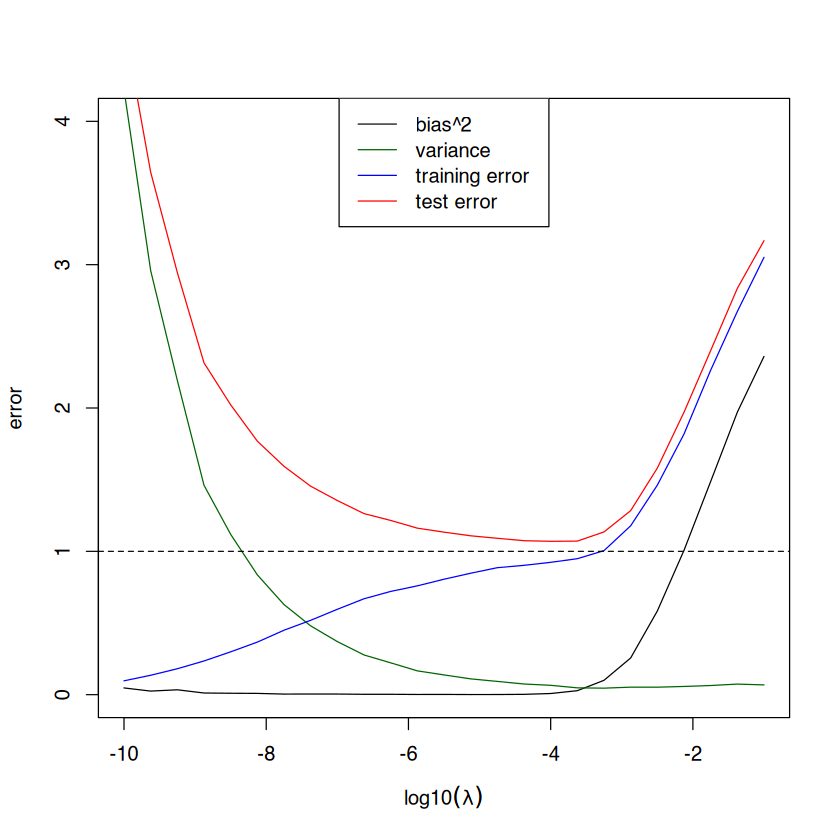

In [83]:
lambdas <- 10^seq(-10, -1, length = 25)
result <- sapply(lambdas, bias.variance)
plot(log10(lambdas), result[1,], col = "black", type = "l",
     ylim = c(0, 4),
     xlab = expression(log10(lambda)), ylab = "error")
lines(log10(lambdas), result[2,], col = "darkgreen")
lines(log10(lambdas), result[3,], col = "red")
lines(log10(lambdas), result[4,], col = "blue")
abline(h = 1, lty = "dashed")
legend("top", legend = c("bias^2", "variance", "training error", "test error"),
       col = c("black", "darkgreen", "blue", "red"), lty = 1)

## Exercises

### Conceptual
**Q1.** Suppose we use the feature functions $h_1(X) = X$, $h_2(X) = (X -
1)^2I(X\ge 1)$ to fit the linear regression model
$Y = \beta_0 + \beta_1h_1(X) + \beta_2h_2(X) + \varepsilon,$
and obtain coefficient estimates $\hat{\beta}_0 = 1$, $\hat{\beta}_1 = 1$, $\hat{\beta}_2 = -2$.
Sketch the estimated curve between $X = -2$ and $X = 2$.

**Q2.** Suppose that a curve $\hat{g}$ is computed to smoothly fit a set of $n$ points using the following formula
$\hat{g} = \arg\min_g\Biggl(\sum_{i=1}^n(y_i - g(x_i))^2 +
\lambda\int[g^{(m)}(x)]^2dx\biggr),$
where $g^{(m)}$ represents the mth derivative of $g$ (and $g^{(0)} = g$). Provide example sketches of $\hat{g}$ in each of the following scenarios.

(a) $\lambda = \infty$, $m = 0$.

(b) $\lambda = \infty$, $m = 1$.

(c) $\lambda = \infty$, $m = 2$.

(d) $\lambda = \infty$, $m = 3$.

(e) $\lambda = 0$, $m = 3$.


### Applied

**Q3.** In this exercise, you will analyse the `Wage` data set contained in the
library ISLR. You can load it with `library(ISLR)` and get information with
`?Wage`.

(a) Perform polynomial regression to predict `wage` using `age`. Use
cross-validation to select the optimal degree $d$ for the polynomial. Make a
plot of the resulting polynomial fit to the data.

(b) Fit a natural spline to predict `wage` using `age` and some hand-picked
knots.

(c) Instead of providing hand-picked knots, use the `df` argument of the `ns`
function and let the method pick the knots automatically. Perform
cross-validation to choose the optimal number of knots (i.e. optimal degree of
freedom `df`) and make a plot of the fit obtained.

(d) The "Wage" data set contains a number of other features, such as marital
status ("marit1"), job class ("jobclass"), and others. Explore the relationships
between some of these other predictors and "wage", and design some features in
order to fit different models to the data.
Create plots of the results obtained, and write a summary of your findings.

**Q4.** In the video on the vector features we used 4 feature vectors to find a
solution to the XOR problem.

(a) Try to find a solution to the XOR problem with only 3 feature vectors.

(b) Try to find a solution to the XOR problem with 5 feature vectors.